<a target="_blank" href="https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/src/notebooks/2_house_price_feature_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [18]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


In [19]:
!pip install scikit-learn==1.5.2

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [20]:
!pip uninstall xgboost -y

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


In [21]:
!pip install xgboost==2.1.3

  Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)


In [22]:
!pip install hopsworks[python]

## Imports

In [23]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import hopsworks
from hopsworks.hsfs.builtin_transformations import label_encoder
from hopsworks import udf
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import warnings
warnings.filterwarnings("ignore")

## Connect to Hopsworks Feature Store

In [24]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = "DMT7cBmSbXxvrmlm.SGi5E7zfqXqjsMJWWgiJFpiMlQep8mMiP5hAlvVCIVBXw5nCOzV67kVhGxIua122"
proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()
ms = proj.get_model_serving()

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158295


## Get feature view and latest data

In [25]:
feature_view = fs.get_feature_view("house_price_fv", 5)

In [26]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=TEST_SIZE,
    description='house price training dataset',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 


## Retrain the model

In [27]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "house_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [28]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [29]:
# Predicting target values on the test set
y_pred = best_model.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 26982919338.538036
R squared: 0.8276609982020513


In [30]:
df = y_test
df['predicted_price'] = y_pred
df = df.sort_values(by="price").reset_index(drop=True)
df.head(5)

,price,predicted_price
0,35000.0,72810.023438
1,47000.0,63266.773438
2,55000.0,76646.437500
3,55000.0,56229.046875
4,56000.0,97052.515625


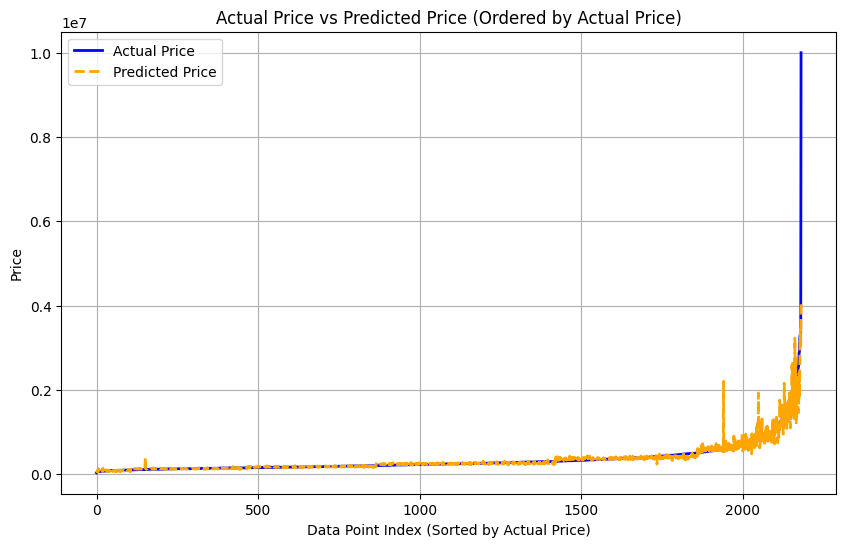

In [31]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df.index, df["price"], label="Actual Price", color='blue', linewidth=2)
plt.plot(df.index, df["predicted_price"], label="Predicted Price", color='orange', linestyle='--', linewidth=2)

# Labels, Title, and Legend
plt.xlabel("Data Point Index (Sorted by Actual Price)")
plt.ylabel("Price")
plt.title("Actual Price vs Predicted Price (Ordered by Actual Price)")
plt.legend()

# Grid
plt.grid(True)

# Save the plot to the desired file path
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = images_dir + "/price_hindcast.png"
plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

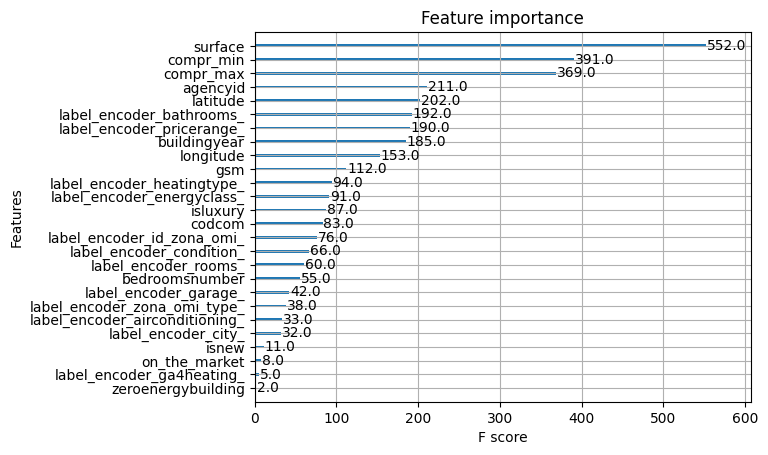

In [32]:
plot_importance(best_model, importance_type='weight')
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

## Update Model Registry

In [33]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [34]:
# Saving the XGBoost regressor object as a json file in the model directory
best_model.save_model(model_dir + "/model.json")

In [35]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [37]:
hp_model = mr.python.create_model(
    name="house_price_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,                    # Add a feature view to the model
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Italian house price predictor",
)

# Saving the model artifacts to the 'house_price_model' directory in the model registry
hp_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/465401 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/145436 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/61439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2379 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1158295/models/house_price_xgboost_model/18


Model(name: 'house_price_xgboost_model', version: 18)

## Create new deployment

In [38]:
retrieved_models = mr.get_models("house_price_xgboost_model")
retrieved_models

[Model(name: 'house_price_xgboost_model', version: 13),
 Model(name: 'house_price_xgboost_model', version: 18),
 Model(name: 'house_price_xgboost_model', version: 8),
 Model(name: 'house_price_xgboost_model', version: 14),
 Model(name: 'house_price_xgboost_model', version: 15),
 Model(name: 'house_price_xgboost_model', version: 16),
 Model(name: 'house_price_xgboost_model', version: 1)]

In [39]:
# Get latest version
sorted_models = sorted(retrieved_models, key=lambda x: x.version)
latest_model = sorted_models[-1]
latest_model

Model(name: 'house_price_xgboost_model', version: 18)

In [42]:
deployment = ms.get_deployment("house")

In [43]:
# Delete the old deployment
deployment.delete(force=True)

Deployment deleted successfully


In [50]:
predictor_script_path = os.path.join("/Projects", proj.name, "Models", "predict_house_price.py")
predictor_script_path

'/Projects/id2223_group_17_labs/Models/predict_house_price.py'

In [52]:
# Deploy the new model
deployment = latest_model.deploy(
    name="house",                 # Specify the deployment name
    script_file=predictor_script_path,  # Provide the path to the predictor script
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/1158295/deployments/352270
Before making predictions, start the deployment by using `.start()`


In [53]:
# Start the deployment and wait for it to be running, with a maximum waiting time of 180 seconds
deployment.start(await_running=180)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`
